In [1]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
import os 
dir_path = os.getcwd()

print(dir_path)

device = 'cuda'
model_path='weights/icon_detect_v1_5/model_v1_5.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

/home/tianl/src/omniparser_demo
model to cuda


In [2]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [4]:
# reload utils
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

# image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
# image_path = 'imgs/word.png'
image_path = 'demo_sample/word2_origin.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.8}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (3240, 2160)

image 1/1 /home/tianl/src/omniparser_demo/demo_sample/word2_origin.png: 864x1280 124 icons, 75.3ms
Speed: 9.3ms preprocess, 75.3ms inference, 31.5ms postprocess per image at shape (1, 3, 864, 1280)


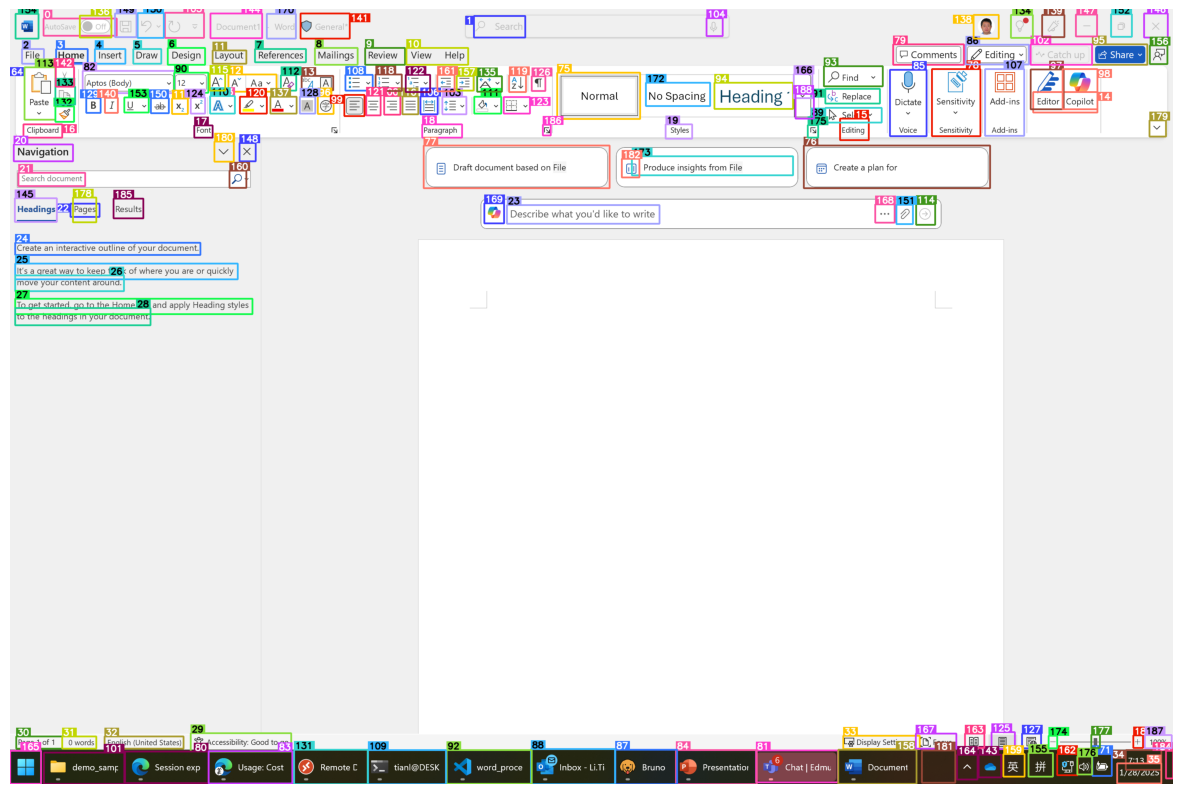

In [5]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [6]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,ID
0,text,"[0.029012344777584076, 0.012500000186264515, 0...",False,AutoSave O off),0
1,text,"[0.3987654447555542, 0.008796296082437038, 0.4...",False,O Search,1
2,text,"[0.010493827052414417, 0.05138888955116272, 0....",False,File,2
3,text,"[0.03950617462396622, 0.05138888955116272, 0.0...",False,Home,3
4,text,"[0.07283950597047806, 0.05138888955116272, 0.0...",False,Insert,4
...,...,...,...,...,...
184,icon,"[0.9939082264900208, 0.9571347832679749, 1.0, ...",True,Search or magnifying glass.,184
185,icon,"[0.08910702168941498, 0.24447275698184967, 0.1...",True,results.,185
186,icon,"[0.458294153213501, 0.14938600361347198, 0.465...",True,New,186
187,icon,"[0.9757100343704224, 0.9367512464523315, 0.998...",True,a percentage value.,187


In [7]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.029012344777584076,
   0.012500000186264515,
   0.09166666865348816,
   0.034259259700775146],
  'interactivity': False,
  'content': 'AutoSave O off)'},
 {'type': 'text',
  'bbox': [0.3987654447555542,
   0.008796296082437038,
   0.44290122389793396,
   0.036574073135852814],
  'interactivity': False,
  'content': 'O Search'},
 {'type': 'text',
  'bbox': [0.010493827052414417,
   0.05138888955116272,
   0.029012344777584076,
   0.07037036865949631],
  'interactivity': False,
  'content': 'File'},
 {'type': 'text',
  'bbox': [0.03950617462396622,
   0.05138888955116272,
   0.06666667014360428,
   0.07037036865949631],
  'interactivity': False,
  'content': 'Home'},
 {'type': 'text',
  'bbox': [0.07283950597047806,
   0.05138888955116272,
   0.09907407313585281,
   0.07037036865949631],
  'interactivity': False,
  'content': 'Insert'},
 {'type': 'text',
  'bbox': [0.1061728373169899,
   0.05138888955116272,
   0.13024690747261047,
   0.07037036865949631],


In [8]:
image.save("output.png", "png")

In [11]:
import json
with open("demo_sample/word2_annotation.json","w") as file:
    file.write(json.dumps(parsed_content_list))